In [1]:
%load_ext autoreload
%autoreload 2
import torch
torch.cuda.set_device(0)
import os
import pickle
from deepprotein.runners.inferencer import LazyInferencer

/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/deepprotein/runners/evaluator.py:12: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  class Evaluator(DeepProteinRunner):


### utils

In [2]:
import numpy as np

def convert_dotbracket_to_matrix(s):
    m = np.zeros([len(s), len(s)])
    for char_set in [['(', ')'], ['[', ']'], ['{', '}'], ['<', '>']]:
        bp1 = []
        bp2 = []
        for i, char in enumerate(s):
            if char == char_set[0]:
                bp1.append(i)
            if char == char_set[1]:
                bp2.append(i)
        for i in list(reversed(bp1)):
            for j in bp2:
                if j > i:
                    m[i, j] = 1.0
                    bp2.remove(j)
                    break
    return m + m.T


def convert_matrix_to_dotbracket(m):
    bp_list = convert_matrix_to_bp_list(m)
    return convert_bp_list_to_dotbracket(bp_list, len(m))


def convert_matrix_to_bp_list(m):
    bp_list = []  # convert adjacency matrix to adjacency list
    for i, row in enumerate(m):
        for j, is_bp in enumerate(row[i + 1:]):
            if is_bp:
                bp_list.append((i, i + 1 + j))
    return bp_list


def convert_bp_list_to_dotbracket(bp_list,seq_len):
    dotbracket = "."*seq_len
    # group into bps that are not intertwined and can use same brackets!
    groups = group_into_non_conflicting_bp_(bp_list)

    # all bp that are not intertwined get (), but all others are
    # groups to be nonconflicting and then asigned (), [], {}, <> by group
    chars_set = [("(", ")"), ("(", ")"), ("[", "]"), ("{", "}"), ("<", ">")]
    if len(groups) > len(chars_set):
        print(f"WARNING: PK too complex with {len(groups)} groups, not enough brackets to represent it.")

    for group,chars in zip(groups,chars_set):
        for bp in group:
            dotbracket = dotbracket[:bp[0]] + chars[0] + dotbracket[bp[0]+1:bp[1]] + chars[1] + dotbracket[bp[1]+1:]
    return dotbracket


def load_matrix_or_dbn(s):
    num_lines = sum(1 for line in open(s))

    if num_lines > 2:  # heuristic here
        struct = np.loadtxt(s)  # load as base pair matrix
        assert struct.shape[0] == struct.shape[1]
    else:
        try:  # load as dot-bracket string

            dbn_struct = open(s, 'r').read().rstrip()

            struct = convert_dotbracket_to_matrix(dbn_struct)
        except:
            raise ValueError('Unable to parse structure %s' % s)
    return struct


def group_into_non_conflicting_bp_(bp_list):
    ''' given a conflict list from get_list_bp_conflicts_, group basepairs into groups that do not conflict

    Args
        conflict_list: list of pairs of base_pairs that are intertwined basepairs

    Returns:
        groups of baspairs that are not intertwined
    '''
    conflict_list = get_list_bp_conflicts_(bp_list)

    non_redudant_bp_list = get_non_redudant_bp_list_(conflict_list)
    bp_with_no_conflict = [bp for bp in bp_list if bp not in non_redudant_bp_list]
    groups = [bp_with_no_conflict]
    while non_redudant_bp_list != []:
        current_bp = non_redudant_bp_list[0]
        current_bp_conflicts = []
        for conflict in conflict_list:
            if current_bp == conflict[0]:
                current_bp_conflicts.append(conflict[1])
            elif current_bp == conflict[1]:
                current_bp_conflicts.append(conflict[0])
        group = [bp for bp in non_redudant_bp_list if bp not in current_bp_conflicts]
        groups.append(group)
        non_redudant_bp_list = current_bp_conflicts
        conflict_list = [conflict for conflict in conflict_list if
                         conflict[0] not in group and conflict[1] not in group]
    return groups


def get_list_bp_conflicts_(bp_list):
    '''given a bp_list gives the list of conflicts bp-s which indicate PK structure
    Args:
        bp_list: of list of base pairs where the base pairs are list of indeces of the bp in increasing order (bp[0]<bp[1])
    returns:
        List of conflicting basepairs, where conflicting is pairs of base pairs that are intertwined.
    '''
    if len(bp_list) <= 1:
        return []
    else:
        current_bp = bp_list[0]
        conflicts = []
        for bp in bp_list[1:]:
            if (bp[0] < current_bp[1] and current_bp[1] < bp[1]):
                conflicts.append([current_bp, bp])
        return conflicts + get_list_bp_conflicts_(bp_list[1:])


def get_non_redudant_bp_list_(conflict_list):
    ''' given a conflict list get the list of nonredundant basepairs this list has

    Args:
        conflict_list: list of pairs of base_pairs that are intertwined basepairs
    returns:
        list of basepairs in conflict list without repeats
    '''
    non_redudant_bp_list = []
    for conflict in conflict_list:
        if conflict[0] not in non_redudant_bp_list:
            non_redudant_bp_list.append(conflict[0])
        if conflict[1] not in non_redudant_bp_list:
            non_redudant_bp_list.append(conflict[1])
    return non_redudant_bp_list

import re
import math
import numpy as np

def adjacency_matrix_to_bpseq(adj_matrix):
    L = len(adj_matrix)
    bpseq = [-1] * L  # 初始化bpseq列表，假设所有位置最初都没有配对

    for i in range(L):
        for j in range(L):
            if adj_matrix[i][j] == 1:
                bpseq[i] = j
                break  # 当找到配对时，跳出内层循环

    return bpseq

def compute_expected_accuracy(etp, efp, efn):
    sen = ppv = f = 0.
    if etp + efn != 0:
        sen = etp / (etp + efn)
    else:
        sen = 0.
        
    if etp + efp != 0:
        ppv = etp / (etp + efp)
    else:
        ppv = 0.
        
    if sen + ppv != 0:
        f = 2 * sen * ppv / (sen + ppv)
    else:
        f = 0.

    return (sen, ppv, f)

def compute_expected_accuracy_pk(pred, label):
    
    # L = len(label)
    # L2 = L * (L - 1) // 2
    N = 0
    pk_flag = False
    
    sump = 0.0
    etp = 0.0
    
    for i in range(len(label)):
        j = label[i]
        if i < j:
            for k in range(i + 1, j):
                l = label[k]
                lp = pred[k]
                if j < lp:
                    N += 1 # TP+FP
                if j < l:
                    sump += 1 # TP+FN
                    if pred[i] == j and pred[k] == l:
                        etp += 1 # TP
    
    efp = N - etp
    efn = sump - etp
    
    if sump > 0:
        pk_flag = True

    return compute_expected_accuracy(etp, efn, efp), pk_flag



def apc(x):
    "Perform average product correct, used for contact prediction."
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)

    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    normalized = x - avg
    return normalized

## MXfold2

### Preprocessing

In [3]:
ckpt_unirna = "/mnt/wangxi/ss-log/ss-interfam/mxfold2-bh3-baseline-b2g32-hinge-Run-o354j2J826f6e4f8ba/checkpoints/epoch-19.pth"
ckpt_rinalmo = "/mnt/wangxi/ss-log/mxfold2/archiveii-rinalmo-Auto-multimolecule_rinalmo-fusion-null-71499ea0-731f78/k6HNY1khm/checkpoints/best.pth"
data_list = "/mnt/siduanmiao/mxfold2/archiveII.pkl"
data_label = pickle.load(open(data_list, "rb"))

In [4]:
with open("result_unirna_archiveII.pkl", "rb") as f:
    result_unirna = pickle.load(f)

with open("result_rinalmo_archiveII.pkl", "rb") as f:
    result_rinalmo = pickle.load(f)

In [3]:
if os.path.exists("result_unirna_archiveII.pkl"):
    with open("result_unirna_archiveII.pkl", "rb") as f:
        result_unirna = pickle.load(f)
else:
    from deepprotein.runners.inferencer import LazyInferencer
    infer = LazyInferencer(ckpt_unirna, batch_size=1)
    result_unirna = infer.run(data_list)
    with open("result_unirna_archiveII.pkl", "wb+") as f:
        pickle.dump(result_unirna, f)

if os.path.exists("result_rinalmo_archiveII.pkl"):
    with open("result_rinalmo_archiveII.pkl", "rb") as f:
        result_rinalmo = pickle.load(f)
else:
    from deepprotein.runners.inferencer import LazyInferencer
    infer = LazyInferencer(ckpt_rinalmo, batch_size=1)
    result_rinalmo = infer.run(data_list)
    with open("result_rinalmo_archiveII.pkl", "wb+") as f:
        pickle.dump(result_rinalmo, f)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fea020d0ac0>>
Traceback (most recent call last):
  File "/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [5]:
color_dict = {
        "Uni-RNA": "#D95F02",
        "RiNALMo": "#7570B3",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
        "ipknot": "#78B4A8"
    }
# 78B4A8 DAA0A0

In [ ]:
import os
import pickle 
import numpy as np

data_label = pickle.load(open(data_list, "rb"))
data_dir = "/mnt/siduanmiao/benchmark_store_sdm/changeformatdata/"
benchmark_name = "benchmark_6_archiveII.pkl"
all_method = os.listdir(data_dir)

all_method.remove("SPOTRNA")
all_method

In [51]:
import os
import pickle 
import numpy as np
from sklearn.metrics import f1_score
import warnings
from tqdm import tqdm

# Ignore RuntimeWarning
warnings.filterwarnings("ignore")

all_score_unirna = []
all_score_unirna_pk = []
all_score_unirna_pk_sample = []

all_score_rinalmo = []
all_score_rinalmo_pk = []
all_score_rinalmo_pk_sample = []

length_list = []
pk_sample_indices = []

for i in tqdm(range(len(data_label))):
    id = data_label[i]['id']
    label = data_label[i]['label']
    
    pred = np.array(result_unirna["label"][i])
    pred = np.where(pred > 0.5, 1, 0)
    f1 = f1_score(label.reshape(-1), pred.reshape(-1))
    all_score_unirna.append(f1)
    pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(pred), adjacency_matrix_to_bpseq(label))
    if pk_metrics[-1]:
        all_score_unirna_pk.append(pk_metrics[0][-1])
        all_score_unirna_pk_sample.append(f1)
        pk_sample_indices.append(i)
        
    # pred = np.array(result_rinalmo["label"][i])
    # pred = np.where(pred > 0.5, 1, 0)
    # f1 = f1_score(label.reshape(-1), pred.reshape(-1))
    # all_score_rinalmo.append(f1)
    # pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(pred), adjacency_matrix_to_bpseq(label))
    # if pk_metrics[-1]:
    #     all_score_rinalmo_pk.append(pk_metrics[0][-1])
    #     all_score_rinalmo_pk_sample.append(f1)
        
    length_list.append(len(data_label[i]["seq"]))

# import warnings
# # Ignore RuntimeWarning
# warnings.filterwarnings("ignore")
# methods_score = []
# methods_score_pk = []
# methods_score_pk_sample = []

# for method in all_method:
#     if method == "SPOTRNA":
#         continue
#     single_method = []
#     single_method_pk = []
#     single_method_pk_sample = []
#     print("Processing", method)
#     method_path = os.path.join(data_dir, method, benchmark_name)
#     data = pickle.load(open(method_path, "rb"))
#     for i in range(len(data_label)):
#         label = data_label[i]['label']
#         method_pred = np.array(data[i]["label"])
#         method_pred = np.where(method_pred > 0.5, 1, 0)
#         f1 = f1_score(label.reshape(-1), method_pred.reshape(-1))
#         single_method.append(f1)
#         pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(method_pred), adjacency_matrix_to_bpseq(label))
#         if pk_metrics[-1]:
#             single_method_pk.append(pk_metrics[0][-1])
#             single_method_pk_sample.append(f1)
            
#     methods_score_pk.append(single_method_pk)
#     methods_score_pk_sample.append(single_method_pk_sample)
#     methods_score.append(single_method)
    
# f1_mxfold2 = {
#     "length":length_list,
#     "unirna":all_score_unirna,
#     "unirna_pk": all_score_unirna_pk,
#     "unirna_pk_sample": all_score_unirna_pk_sample,
#     "methods":methods_score,
#     "methods_pk": methods_score_pk,
#     "methods_pk_sample": methods_score_pk_sample,
#     "method_name":all_method
# }

# with open("all_mxfold_f1.pkl", "wb+") as f:
#     pickle.dump(f1_mxfold2, f)

100%|██████████| 3966/3966 [01:58<00:00, 33.61it/s] 


In [4]:
with open("all_mxfold_f1.pkl", "rb") as f:
    f1_mxfold2 = pickle.load(f)
    
length_list = f1_mxfold2["length"]
all_score_unirna = f1_mxfold2["unirna"]
all_score_unirna_pk = f1_mxfold2["unirna_pk"]
all_score_unirna_pk_sample = f1_mxfold2["unirna_pk_sample"]

all_score_rinalmo = f1_mxfold2["rinalmo"]
all_score_rinalmo_pk = f1_mxfold2["rinalmo_pk"]
all_score_rinalmo_pk_sample = f1_mxfold2["rinalmo_pk_sample"]

methods_score = f1_mxfold2["methods"]
methods_score_pk = f1_mxfold2["methods_pk"]
methods_score_pk_sample = f1_mxfold2["methods_pk_sample"]

all_method = f1_mxfold2["method_name"]

In [9]:
np.array(all_score_rinalmo_pk_sample).mean()


np.float64(0.750408800460952)

### Boxplot

#### Pseudoknots-free

/tmp/ipykernel_437774/2746951407.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_437774/2746951407.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_437774/2746951407.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.

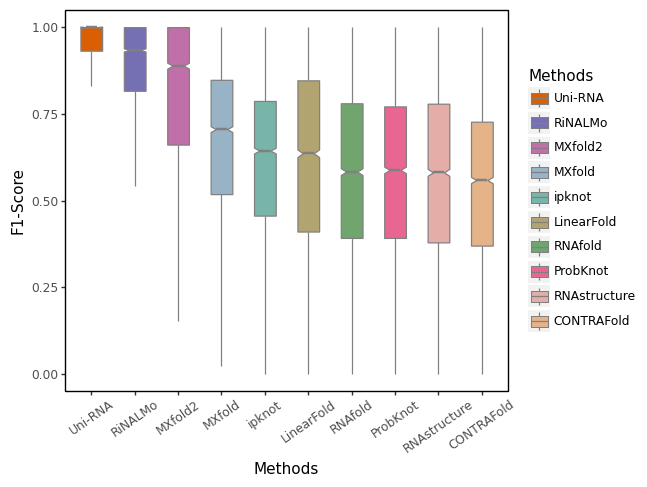

In [10]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]

    # B78FB2 97B3C5 78B4A8 70A56E B1A471 DAA0A0 E5ADA8 E96692 C06FA9 E4B488
    # 绘制盒型图
    
    color_dict = {
        "Uni-RNA": "#D95F02",
        "RiNALMo": "#7570B3",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
        "ipknot": "#78B4A8"
    }
    
    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    # stat_summary(fun_data='median_hilow', geom='errorbar', color='red', width=0.2) +  # 添加平均线
    # geom_jitter(color="#97B3C5", width=0.1, size=0.5, alpha=0.1) +  # 设置散点的颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

# 示例数据
if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")
scores = [all_score_unirna] + [all_score_rinalmo] + methods_score
method_names = ["Uni-RNA"] + ["RiNALMo"] + all_method
filter_score = []
for score in scores:
    filter_score.append(random.sample(score, 200))
plot = plot_box(scores, method_names)
plot.save("mxfold2-box.svg", dpi=600)
plot.draw()

In [ ]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))

#### Pseudoknoted

/tmp/ipykernel_437774/3298830623.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_437774/3298830623.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_437774/3298830623.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.

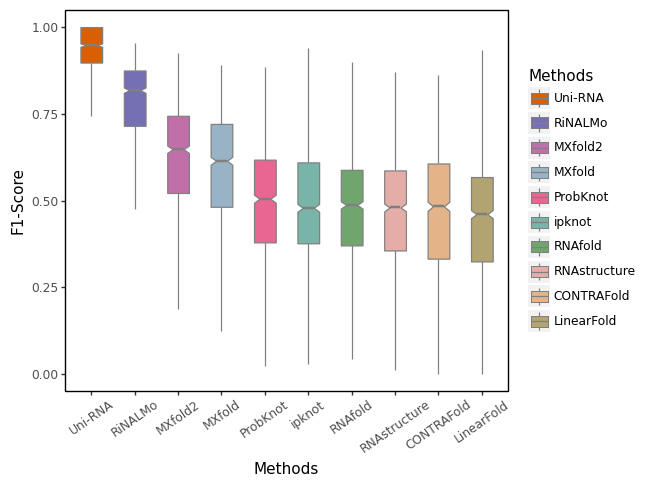

In [11]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]

    # B78FB2 97B3C5 78B4A8 70A56E B1A471 DAA0A0 E5ADA8 E96692 C06FA9 E4B488
    # 绘制盒型图
    
    color_dict = {
        "Uni-RNA": "#D95F02",
        "RiNALMo": "#7570B3",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
        "ipknot": "#78B4A8"
    }
    
    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    # stat_summary(fun_data='median_hilow', geom='errorbar', color='red', width=0.2) +  # 添加平均线
    # geom_jitter(color="#97B3C5", width=0.1, size=0.5, alpha=0.1) +  # 设置散点的颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

# 示例数据
if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")
scores = [all_score_unirna_pk_sample] + [all_score_rinalmo_pk_sample] + methods_score_pk_sample
method_names = ["Uni-RNA"] + ["RiNALMo"] + all_method
plot = plot_box(scores, method_names)
plot.save("mxfold2-box-pk-sample.svg", dpi=600)
plot.draw()

In [ ]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))     

#### Crossing base pair

/tmp/ipykernel_437774/163444420.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/tmp/ipykernel_437774/163444420.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_437774/163444420.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x

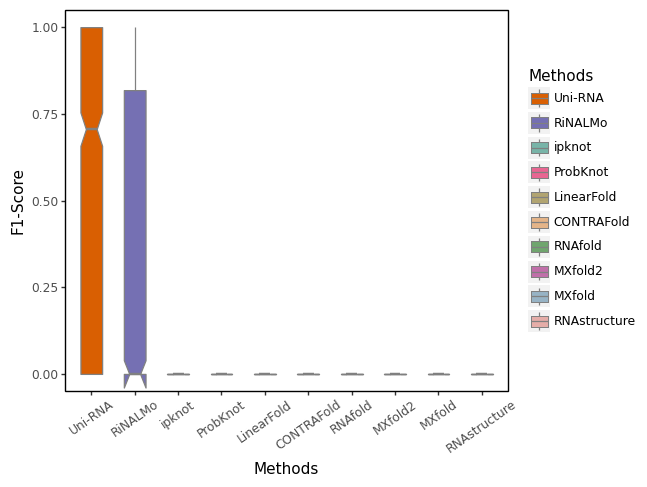

In [12]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]

    # B78FB2 97B3C5 78B4A8 70A56E B1A471 DAA0A0 E5ADA8 E96692 C06FA9 E4B488
    # 绘制盒型图
    
    color_dict = {
        "Uni-RNA": "#D95F02",
        "RiNALMo": "#7570B3",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
        "ipknot": "#78B4A8"
    }
    
    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    # stat_summary(fun_data='median_hilow', geom='errorbar', color='red', width=0.2) +  # 添加平均线
    # geom_jitter(color="#97B3C5", width=0.1, size=0.5, alpha=0.1) +  # 设置散点的颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

# 示例数据
if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")
scores = [all_score_unirna_pk] + [all_score_rinalmo_pk] + methods_score_pk
method_names = ["Uni-RNA"] + ["RiNALMo"] + all_method
plot = plot_box(scores, method_names)
plot.save("mxfold2-box-pk-cb.svg", dpi=600)
plot.draw()

In [ ]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))     

### Cross-Families

In [59]:
import re
import numpy as np
import copy
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef


all_classes = []

for i in range(len(data_label)):
    match = re.search(r'archiveII_(.*?)_', data_label[i]["id"])
    extracted_content = match.group(1)
    all_classes.append(extracted_content)
    
# 假设您有一个包含所有方法名称的列表
methods_list = all_method + ["unirna"] + ["RiNALMo"]

all_classes = list(set(all_classes))
result_dict = {}
for fam in all_classes:
    result_dict[fam] = {'f1': [], 'precision': [], 'recall': [], 'mcc': []}


In [60]:
result_dict.keys()

dict_keys(['23s', 'tmRNA', '5s', 'telomerase', 'tRNA', 'grp1', 'grp2', 'srp', 'RNaseP', '16s'])

In [65]:
# # 对于每种方法计算度量值
# for method in methods_list:
#     method_path = os.path.join(data_dir, method, benchmark_name)
#     data = pickle.load(open(method_path, "rb"))
#     for i in range(len(data_label)):
#         match = re.search(r'archiveII_(.*?)_', data_label[i]["id"])
#         family_name = match.group(1) if match else "Unknown"
#         extracted_content = match.group(1)
        
#         # 假设每个方法的预测结果存储在一个字典中，键为方法名称
#         pred = np.array(data[i]["label"])
#         pred = np.where(pred > 0.5, 1, 0)
#         label = data_label[i]['label']

#         # 计算度量值
#         f1 = f1_score(label.reshape(-1), pred.reshape(-1))
#         precision = precision_score(label.reshape(-1), pred.reshape(-1))
#         recall = recall_score(label.reshape(-1), pred.reshape(-1))
#         mcc = matthews_corrcoef(label.reshape(-1), pred.reshape(-1))

#         # 将度量值添加到结果字典中
#         if family_name not in results_dict[method].keys():
#             results_dict[method][family_name] = {'f1': [], 'precision': [], 'recall': [], 'mcc': []}

#         results_dict[method][family_name]['f1'].append(f1)
#         results_dict[method][family_name]['precision'].append(precision)
#         results_dict[method][family_name]['recall'].append(recall)
#         results_dict[method][family_name]['mcc'].append(mcc)

# import copy
# results_dict.update({"unirna": copy.deepcopy(result_dict)})
# for fam in all_classes:
#     results_dict["unirna"][fam] = {'f1': [], 'precision': [], 'recall': [], 'mcc': []}

In [61]:
with open("archiveII-metrics-fam.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [62]:
results_dict.keys()

dict_keys(['ProbKnot', 'mxfold2', 'mxfold', 'RNAstructure', 'linearFold', 'RNAfold', 'contrafold', 'unirna'])

In [63]:
import re
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

results_dict.update({"RiNALMo": copy.deepcopy(result_dict)})
    
for i in tqdm(range(len(data_label))):
    match = re.search(r'archiveII_(.*?)_', data_label[i]["id"])
    extracted_content = match.group(1)
    family_name = match.group(1) if match else "Unknown"
    id = data_label[i]['id']
    label = data_label[i]['label']
    
    f1 = all_score_unirna[i]
    f1_rinalmo = all_score_rinalmo[i]
    
    
    results_dict["unirna"][family_name]['f1'].append(f1)
    results_dict["unirna"][family_name]['precision'].append(0)
    results_dict["unirna"][family_name]['recall'].append(0)
    results_dict["unirna"][family_name]['mcc'].append(0)
    
    
    results_dict["RiNALMo"][family_name]['f1'].append(f1_rinalmo)
    results_dict["RiNALMo"][family_name]['precision'].append(0)
    results_dict["RiNALMo"][family_name]['recall'].append(0)
    results_dict["RiNALMo"][family_name]['mcc'].append(0)
    
    length_list.append(label.shape[-1])

100%|██████████| 3966/3966 [00:00<00:00, 324989.93it/s]


In [64]:
results_dict.keys()

dict_keys(['ProbKnot', 'mxfold2', 'mxfold', 'RNAstructure', 'linearFold', 'RNAfold', 'contrafold', 'unirna', 'RiNALMo'])

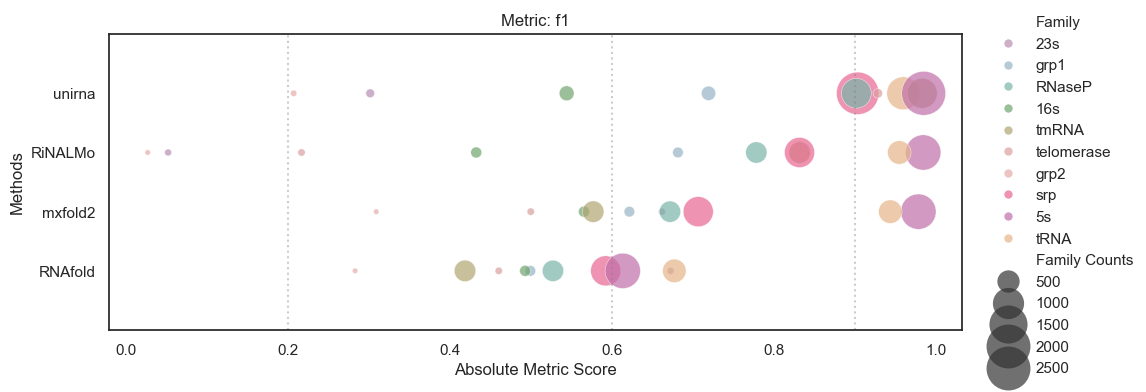

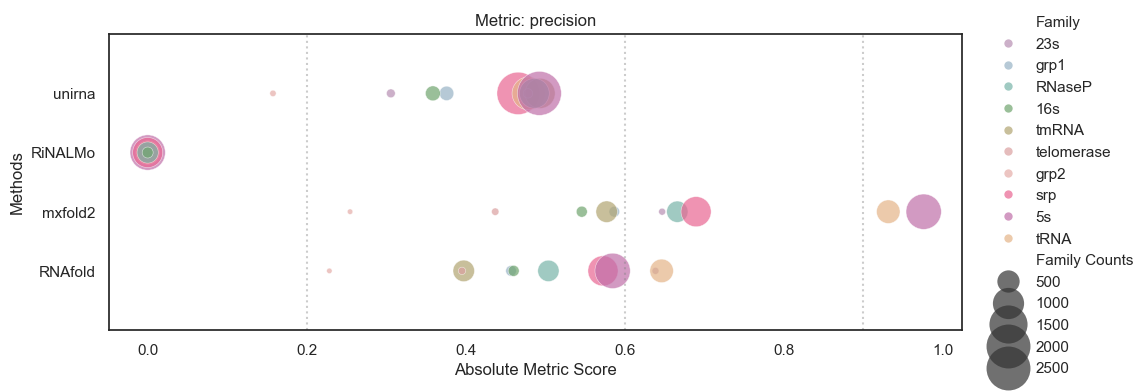

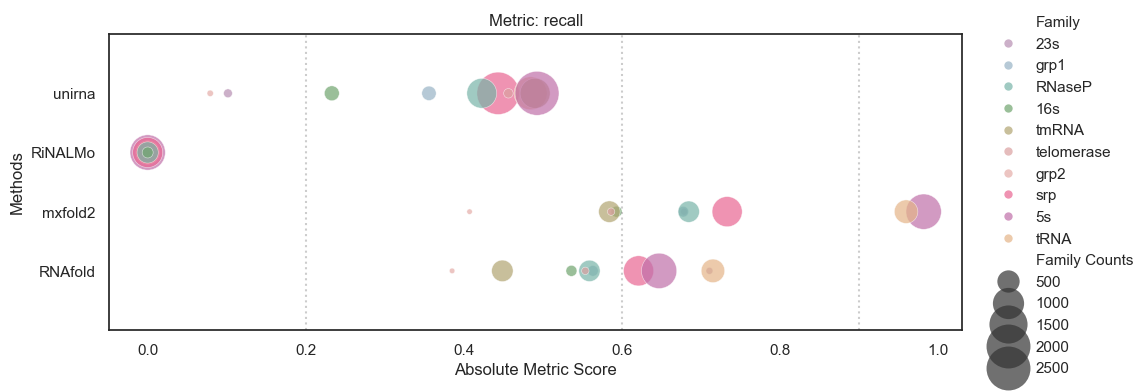

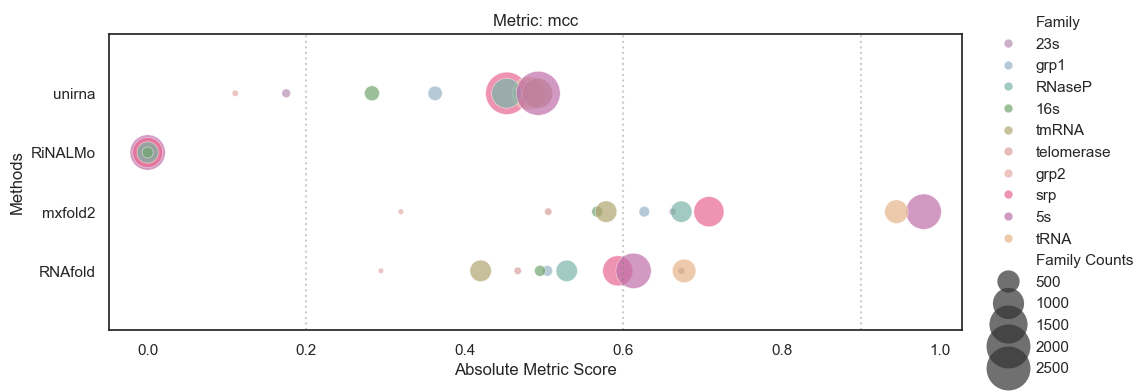

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 示例：多级字典
data = results_dict
metrics = ["f1", "precision", "recall", "mcc"]
color_list = ["#B78FB2", "#97B3C5", "#78B4A8", "#70A56E", "#B1A471", "#DAA0A0", "#E5ADA8", "#E96692", "#C06FA9", "#E4B488"]
# 将字典转换为适合 seaborn 的 DataFrame
records = []
for method, families in data.items():
    if not method in ["unirna", "mxfold2", "RNAfold", "RiNALMo"]:
        continue
    for family, metrics in families.items():
        for metric, values in metrics.items():
            records.append({
                "Methods": method,
                "Family": family,
                "Metric": metric,
                "Score": np.array(values).mean(),
                "Family Counts": len(values)
            })

df = pd.DataFrame(records)
# Set the order of the methods for the y-axis
df['Methods'] = pd.Categorical(df['Methods'], categories=["RNAfold", "mxfold2", "RiNALMo", "unirna"], ordered=True)

plt.close()
sns.set_theme(style="white")
for metric in metrics:
    # 绘制
    g = sns.relplot(
        data=df[df["Metric"] == metric],
        x="Score",
        y="Methods",
        hue="Family",
        size="Family Counts",
        col="Metric",
        kind="scatter",
        size_norm=(0, 2000),
        sizes=(10, 1000),  # 调整点的大小范围
        alpha=0.7,
        aspect=2.5,
        height=4,
        legend=True,
        palette=color_list,
        facet_kws={'sharex': False, 'sharey': False}
    )

    # 添加垂直线
    def add_vline(x, **kwargs):
        plt.axvline(x=x, color='grey', linestyle=':', alpha=0.4)

    g.map(add_vline, x=0.2)
    g.map(add_vline, x=0.6)
    g.map(add_vline, x=0.9)
    
    for ax in g.axes.flat:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
        ax.set_ylim([-1, 4])  # 设置 y 轴范围
    
    g.set_titles("Metric: {col_name}")
    g.set_axis_labels("Absolute Metric Score", "Methods")
    plt.savefig(f"archiveii-fam-{metric}.svg", dpi=600, transparent=True)
    plt.show()

### Cross-fam psudoknots

In [47]:
methods_list

['ipknot',
 'ProbKnot',
 'RNAstructure',
 'LinearFold',
 'CONTRAFold',
 'RNAfold',
 'MXfold',
 'MXfold2',
 'unirna',
 'RiNALMo']

In [69]:
with open("archiveII-metrics-fam.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [70]:
import re
import numpy as np
import copy
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef


all_classes = []

for i in range(len(data_label)):
    match = re.search(r'archiveII_(.*?)_', data_label[i]["id"])
    extracted_content = match.group(1)
    all_classes.append(extracted_content)
    
# 假设您有一个包含所有方法名称的列表
methods_list = all_method + ["unirna"] + ["RiNALMo"]

all_classes = list(set(all_classes))
result_dict = {}
for fam in all_classes:
    result_dict[fam] = {'f1': []}

results_dict = {}
# 为每种方法创建一个包含上述度量指标的字典
for method in methods_list:
    results_dict.update({method: copy.deepcopy(result_dict)})

In [71]:
import re
import numpy as np
from sklearn.metrics import f1_score

for i_, i in enumerate(pk_sample_indices):
    match = re.search(r'archiveII_(.*?)_', data_label[i]["id"])
    extracted_content = match.group(1)
    family_name = match.group(1) if match else "Unknown"
    
    pk_score = all_score_unirna_pk[i_]
    results_dict["unirna"][family_name]['f1'].append(pk_score)
    
    pk_score_rinalmo = all_score_rinalmo_pk[i_]
    results_dict["RiNALMo"][family_name]['f1'].append(pk_score_rinalmo)
    
    for idx, name in enumerate(all_method):
        pk_score = methods_score_pk[idx][i_]
        results_dict[name][family_name]['f1'].append(pk_score)

In [74]:
results_dict["MXfold2"]

{'23s': {'f1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 'tmRNA': {'f1': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   

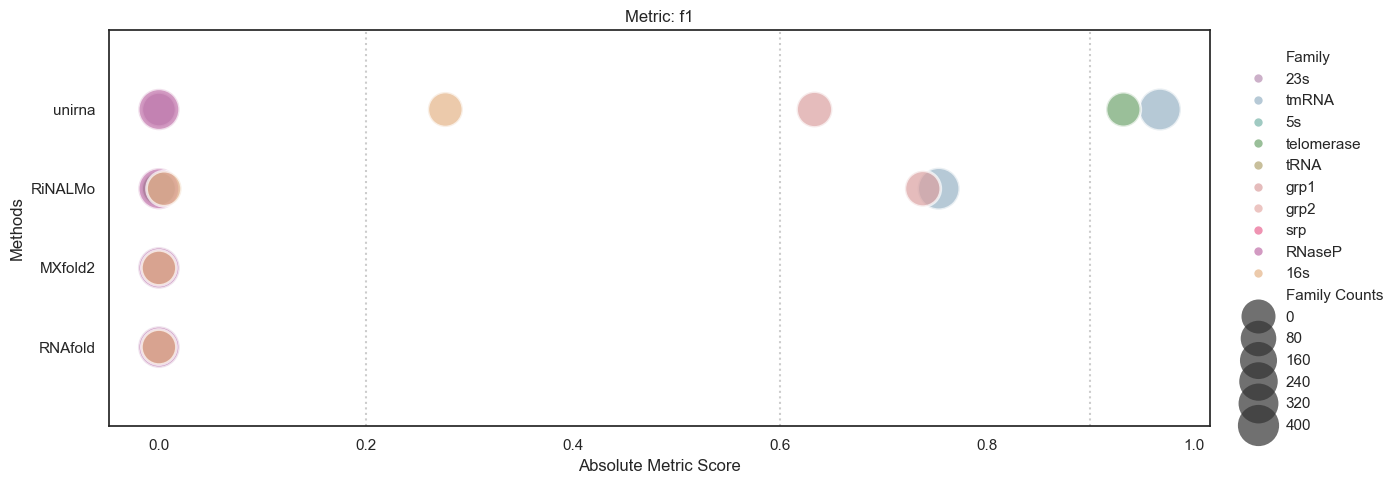

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 示例：多级字典
data = results_dict
metrics = ["f1"]
color_list = ["#B78FB2", "#97B3C5", "#78B4A8", "#70A56E", "#B1A471", "#DAA0A0", "#E5ADA8", "#E96692", "#C06FA9", "#E4B488"]
# 将字典转换为适合 seaborn 的 DataFrame
records = []
for method, families in data.items():
    if not method in ["unirna", "MXfold2", "RNAfold", "RiNALMo"]:
        continue
    for family, metrics in families.items():
        for metric, values in metrics.items():
            records.append({
                "Methods": method,
                "Family": family,
                "Metric": metric,
                "Score": np.array(values).mean(),
                "Family Counts": len(values)
            })

df = pd.DataFrame(records)
# Set the order of the methods for the y-axis
df['Methods'] = pd.Categorical(df['Methods'], categories=["RNAfold", "MXfold2", "RiNALMo", "unirna"], ordered=True)

plt.close()
sns.set_theme(style="white")
for metric in metrics:
    # 绘制
    g = sns.relplot(
        data=df[df["Metric"] == metric],
        x="Score",
        y="Methods",
        hue="Family",
        size="Family Counts",
        col="Metric",
        kind="scatter",
        size_norm=(0, 2000),
        sizes=(600, 2000),  # 调整点的大小范围
        alpha=0.7,
        aspect=2.5,
        height=5,
        legend=True,
        palette=color_list,
        facet_kws={'sharex': False, 'sharey': False}
    )

    # 添加垂直线
    def add_vline(x, **kwargs):
        plt.axvline(x=x, color='grey', linestyle=':', alpha=0.4)

    g.map(add_vline, x=0.2)
    g.map(add_vline, x=0.6)
    g.map(add_vline, x=0.9)
    
    for ax in g.axes.flat:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
        ax.set_ylim([-1, 4])  # 设置 y 轴范围
    
    g.set_titles("Metric: {col_name}")
    g.set_axis_labels("Absolute Metric Score", "Methods")
    plt.savefig(f"archiveii-fam-pk-{metric}.svg", dpi=600, transparent=True)
    plt.show()

In [42]:
length_list = [len(data_label[i]['seq']) for i in range(len(data_label))]

### F1 versus Length

In [ ]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_fill_manual, theme, element_text, element_rect

# 假设 original_data 是包含原始方法数据的 DataFrame
original_data = pd.DataFrame({'sample_length': length_list, 'f1_score': all_score_unirna, 'method': 'Uni-RNA'})

# 假设 new_method_data 是包含新方法数据的 DataFrame
new_method_data = pd.DataFrame({'sample_length': length_list, 'f1_score': methods_score[-1], 'method': 'MXfold2'})

rnafold_method_data = pd.DataFrame({'sample_length': length_list, 'f1_score': methods_score[-3], 'method': 'RNAfold'})

# 合并两个数据集
combined_data = pd.concat([original_data, new_method_data, rnafold_method_data])
combined_data['method'] = pd.Categorical(combined_data['method'], categories=['Uni-RNA', 'MXfold2', 'RNAfold'], ordered=True)


# 处理异常值
# Q1 = combined_data.groupby('method')['f1_score'].quantile(0.25)
# Q3 = combined_data.groupby('method')['f1_score'].quantile(0.75)
# IQR = Q3 - Q1

# for method in combined_data['method'].unique():
#     method_filter = combined_data['method'] == method
#     score_filter = ((combined_data['f1_score'] < (Q1[method] - 1.5 * IQR[method])) | (combined_data['f1_score'] > (Q3[method] + 1.5 * IQR[method])))
#     combined_data.loc[method_filter & score_filter, 'f1_score'] = np.nan  # 可选：将异常值设为NaN或进行其他处理

# 创建长度区间
combined_data['length_group'] = pd.cut(combined_data['sample_length'], bins=[0, 50, 100, 200, 500, 1000, np.inf], labels=['0-50', '51-100', '101-200', '201-500', '501-1000', '1001+'])

# 为了美观，我们可以指定不同方法的颜色
color_dict = {
        "Uni-RNA": "#D95F02",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
    }

group_counts = combined_data.groupby('length_group').size().reset_index(name='counts')
title_with_counts = 'F1 Scores by Sequences Length and Method\n' + \
    '\n'.join([f"{row['length_group']}: {row['counts'] / 3} samples" for index, row in group_counts.iterrows()])
    
print(title_with_counts)

In [ ]:
plot = (ggplot(combined_data) +
        aes(x='length_group', y='f1_score', fill='method') +
        geom_boxplot(color='gray', outlier_alpha=0., outlier_color="#97B3C5") +
        labs(x='Sequences Length Group', y='F1 Score', title='F1 Scores by Sequences Length and Method') +
        theme(axis_text_x=element_text(),
              legend_title=element_text(),  # Corrected line
              panel_background=element_rect(fill='white'),
              panel_border=element_rect(color="black", fill=None, size=1)) +
        scale_fill_manual(values=color_dict))

plot.save("archiveII-box-length.svg")
plot.draw()

### Show case

In [ ]:
all_stru_unirna = []
all_stru = []
methods_stru = []

for i in range(len(data_label)):
    id = data_label[i]['id']
    label = data_label[i]['label']
    all_stru.append(label)
    
    pred = np.array(result_unirna["label"][i])
    all_stru_unirna.append(pred)
        
for method in all_method:
    single_method = []
    method_path = os.path.join(data_dir, method, benchmark_name)
    data = pickle.load(open(method_path, "rb"))
    
    for i in range(len(data_label)):
        seq = data_label[i]['seq']
        method_pred = np.array(data[i]["label"])
        single_method.append(method_pred)
    methods_stru.append(single_method)

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
meta_archive = []
for idx in range(len(data_label)):
    seq = data_label[idx]["seq"]
    label = data_label[idx]["label"]
    id = data_label[idx]["id"]
    pred_unirna = all_stru_unirna[idx]
    pred_mxfold2 = methods_stru[1][idx]
    pred_rnafold = methods_stru[-2][idx]
    f1_unirna = f1_score(np.where(pred_unirna > 0.5, 1, 0).reshape(-1), label.reshape(-1))
    f1_mxfold2 = f1_score(np.where(pred_mxfold2 > 0.5, 1, 0).reshape(-1), label.reshape(-1))
    f1_rnafold = f1_score(np.where(pred_rnafold > 0.5, 1, 0).reshape(-1), label.reshape(-1))
    if f1_unirna - f1_mxfold2 > 0.2 and f1_unirna - f1_rnafold > 0.2:
        meta_archive.append(
            {
                "seq": seq,
                "id": id,
                "label": label,
                "unirna": pred_unirna,
                "mxfold2": pred_mxfold2,
                "rnafold": pred_rnafold
            }
        )
        # fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
        # ax1.imshow(label)
        # ax1.set_title("Ground Truth")  # Corrected line
        # ax2.imshow(pred_unirna)
        # ax2.set_title("UniRNA")       # Corrected line
        # ax3.imshow(pred_mxfold2)
        # ax3.set_title("mxfold2")      # Corrected line
        # ax4.imshow(pred_rnafold)
        # ax4.set_title("RNAfold")      # Corrected line
        # fig.savefig(f"./archive_mat/idx_{idx}_id_{id}.png", dpi=600)
        
        # with open(f"./archive_dbn/idx_{idx}_id_{id}.dbn", "w+") as f:
        #     f.write(">label\n")
        #     f.write(seq + "\n")
        #     f.write(convert_matrix_to_dotbracket(label) + "\n")
        #     f.write(">UniRNA\n")
        #     f.write(seq + "\n")
        #     f.write(convert_matrix_to_dotbracket(np.where(pred_unirna > 0.5, 1, 0)) + "\n")
        #     f.write(">mxfold2\n")
        #     f.write(seq + "\n")
        #     f.write(convert_matrix_to_dotbracket(np.where(pred_mxfold2 > 0.5, 1, 0)) + "\n")
        #     f.write(">RNAfold\n")
        #     f.write(seq + "\n")
        #     f.write(convert_matrix_to_dotbracket(np.where(pred_rnafold > 0.5, 1, 0)) + "\n")
            
with open("archiveII-meta.pkl", "wb+") as f:
    pickle.dump(meta_archive, f)